<a href="https://colab.research.google.com/github/beruscoder/research-to-code/blob/main/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Go to your dataset folder
#%cd /content/drive/MyDrive/pose body estimation

# Unzip (replace with your actual zip filename)
#!unzip FLIC.zip -d ./FLIC/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
print(os.listdir("/content/drive/MyDrive/pose body estimation/FLIC/FLIC"))


['lookupPart.m', 'myplot.m', 'plotbox.m', 'examples.mat', 'demo_FLIC.m', 'images']


In [3]:
import scipy.io

mat = scipy.io.loadmat("/content/drive/MyDrive/pose body estimation/FLIC/FLIC/examples.mat")
print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'examples'])


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import scipy.io

# Load MAT file
mat = scipy.io.loadmat("/content/drive/MyDrive/pose body estimation/FLIC/FLIC/examples.mat")
examples = mat["examples"]

dataset = []

for i in range(examples.shape[1]):
    entry = examples[0, i]

    filepath = entry["filepath"][0]              # string path to image
    coords = entry["coords"]                     # 2 x N array (x,y for joints)
    is_train = bool(entry["istrain"][0, 0])      # 1 if train
    is_test = bool(entry["istest"][0, 0])        # 1 if test

    dataset.append({
        "filepath": filepath,
        "coords": coords,
        "is_train": is_train,
        "is_test": is_test
    })

# Quick check
print("Total samples:", len(dataset))
print("First sample keys:", list(dataset[0].keys()))
print("First sample filepath:", dataset[0]["filepath"])
print("First sample coords shape:", dataset[0]["coords"].shape)

Total samples: 5003
First sample keys: ['filepath', 'coords', 'is_train', 'is_test']
First sample filepath: 12-oclock-high-special-edition-00006361.jpg
First sample coords shape: (2, 29)


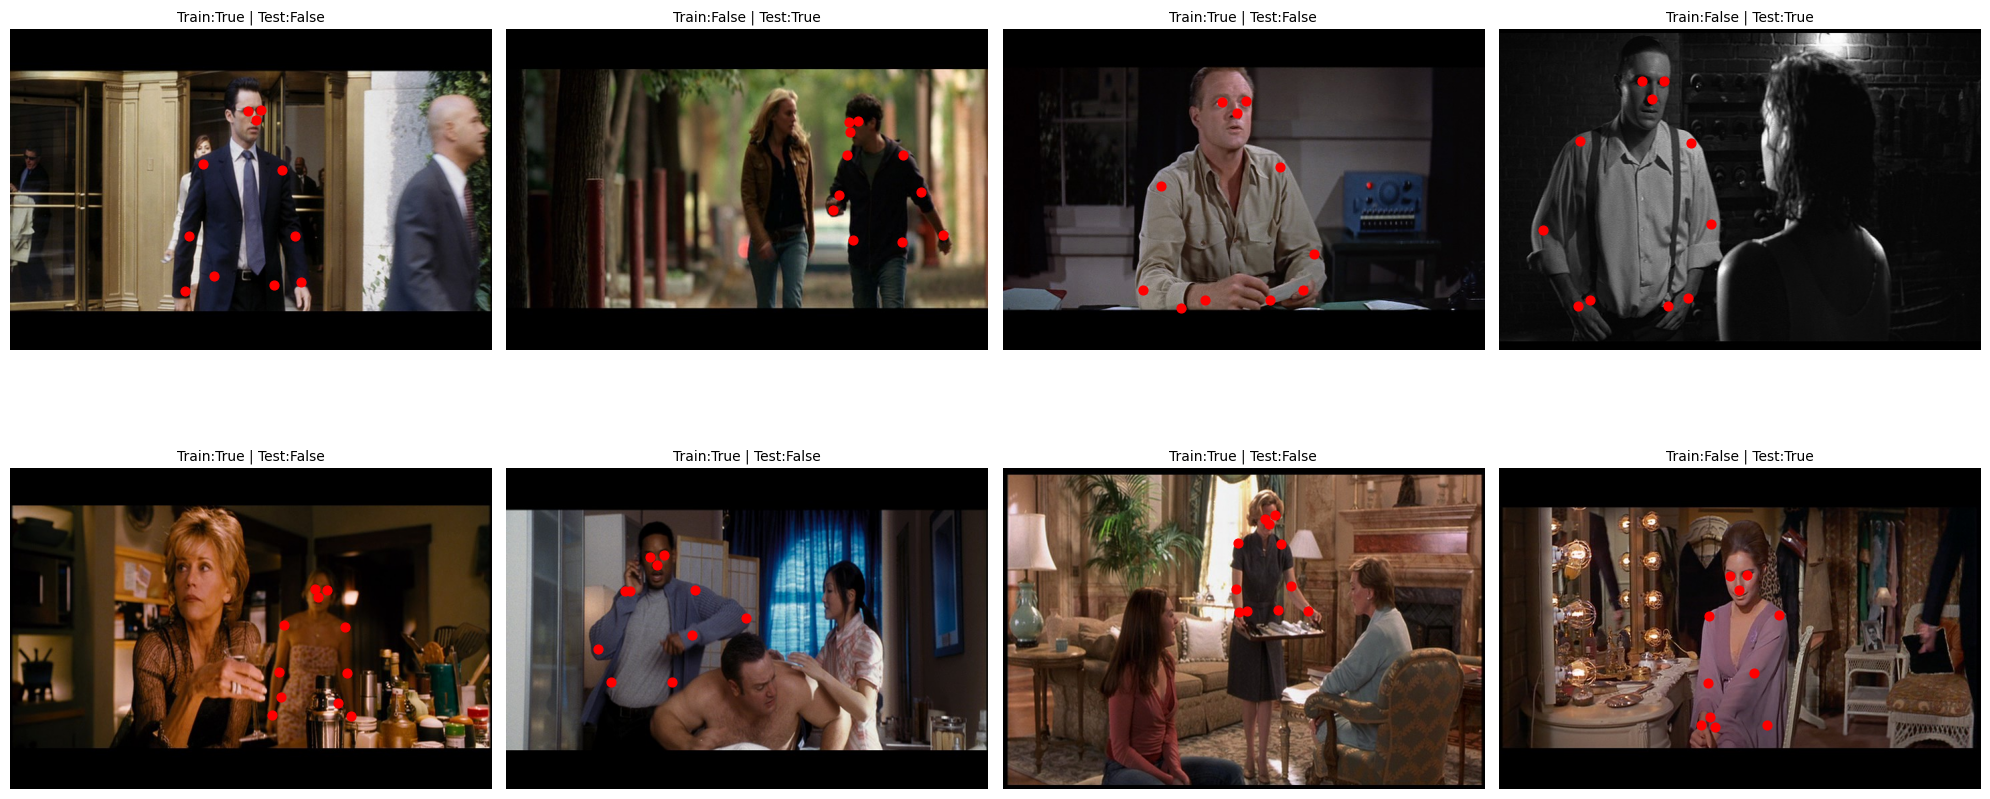

In [5]:
import random
import os
import cv2
import matplotlib.pyplot as plt

img_base = "/content/drive/MyDrive/pose body estimation/FLIC/FLIC/images"

num_samples = 8
samples = random.sample(dataset, num_samples)

cols = 4
rows = (num_samples + cols - 1) // cols  # compute needed rows

plt.figure(figsize=(5*cols, 5*rows))

for i, sample in enumerate(samples):
    img_path = os.path.join(img_base, sample["filepath"])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    coords = sample["coords"]
    x_points, y_points = coords[0, :], coords[1, :]

    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.scatter(x_points, y_points, c='red', s=40, marker='o')
    plt.title(f"Train:{sample['is_train']} | Test:{sample['is_test']}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import os
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import image_dataset_from_directory
from keras.utils import plot_model
from tensorflow.keras.layers import Rescaling


from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, auc

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import scipy.io
from PIL import Image

# Load MAT file
mat = scipy.io.loadmat("/content/drive/MyDrive/pose body estimation/FLIC/FLIC/examples.mat")
examples = mat["examples"]

dataset = []

for i in range(examples.shape[1]):
    entry = examples[0, i]

    filepath = entry["filepath"][0]              # string path to image
    coords = entry["coords"]                     # 2 x N array (x,y for joints)
    is_train = bool(entry["istrain"][0, 0])      # 1 if train
    is_test = bool(entry["istest"][0, 0])        # 1 if test

    dataset.append({
        "filepath": filepath,
        "coords": coords,
        "is_train": is_train,
        "is_test": is_test
    })

# Let's verify the actual image dimensions by loading a sample image
sample_img_path = os.path.join("/content/drive/MyDrive/pose body estimation/FLIC/FLIC/images",
                              dataset[0]["filepath"])
sample_img = Image.open(sample_img_path)
actual_width, actual_height = sample_img.size
print(f"Actual image dimensions: {actual_width}x{actual_height}")

# Parameters - using the actual dimensions we just discovered
orig_width = actual_width
orig_height = actual_height
img_size = (256, 256)
batch_size = 32
img_base = "/content/drive/MyDrive/pose body estimation/FLIC/FLIC/images"

# Build file lists + flattened coords
train_files = [os.path.join(img_base, s["filepath"]) for s in dataset if s["is_train"]]
train_coords = [s["coords"].T.reshape(-1) for s in dataset if s["is_train"]]

test_files = [os.path.join(img_base, s["filepath"]) for s in dataset if s["is_test"]]
test_coords = [s["coords"].T.reshape(-1) for s in dataset if s["is_test"]]

train_files = np.array(train_files)
train_coords = np.array(train_coords, dtype=np.float32)
test_files = np.array(test_files)
test_coords = np.array(test_coords, dtype=np.float32)

print("Raw shapes -> train coords:", train_coords.shape, "test coords:", test_coords.shape)

# Reshape to (N, num_joints, 2)
num_coords = train_coords.shape[1]
if num_coords % 2 != 0:
    raise ValueError("Expected even number of coordinate columns (x,y pairs).")

num_joints_orig = num_coords // 2
train_coords_resh = train_coords.reshape(-1, num_joints_orig, 2)
test_coords_resh = test_coords.reshape(-1, num_joints_orig, 2)

# Find joints that are ALWAYS NaN across training set
joint_all_nan = np.array([np.all(np.isnan(train_coords_resh[:, j, :])) for j in range(num_joints_orig)])
keep_joint_idx = np.where(~joint_all_nan)[0]

print("Original joints:", num_joints_orig)
print("Joints always NaN (count):", int(joint_all_nan.sum()))
print("Kept joints (count):", len(keep_joint_idx), "indices:", keep_joint_idx)

# Filter coords to keep only valid joints
train_coords_filtered = train_coords_resh[:, keep_joint_idx, :]
test_coords_filtered = test_coords_resh[:, keep_joint_idx, :]

# Flatten to (N, K*2) for storage and TF dataset
K = train_coords_filtered.shape[1]
train_coords_flat = train_coords_filtered.reshape(-1, K * 2)
test_coords_flat = test_coords_filtered.reshape(-1, K * 2)

print("After filtering shapes -> train:", train_coords_flat.shape, "test:", test_coords_flat.shape, "K =", K)

# Compute per-joint mean for any remaining NaNs
per_joint_mean = np.nanmean(train_coords_filtered, axis=0)
per_joint_mean = np.where(np.isnan(per_joint_mean), np.array([orig_width/2.0, orig_height/2.0]), per_joint_mean)
per_joint_mean_flat = per_joint_mean.reshape(-1)
per_joint_mean_tf = tf.constant(per_joint_mean_flat, dtype=tf.float32)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.167),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomBrightness(factor=0.2),
])

# Alternative approach: Create a separate function for coordinate processing only
def process_coordinates(label):
    # Ensure label is float32
    label = tf.cast(label, tf.float32)

    # Replace NaNs with per-joint mean
    label = tf.where(tf.math.is_nan(label), per_joint_mean_tf, label)

    # Extract original coordinates
    x_coords = label[::2]  # Even indices: x coordinates
    y_coords = label[1::2]  # Odd indices: y coordinates

    # Scale from original image coordinates to target size
    x_coords = x_coords * (img_size[1] / orig_width)
    y_coords = y_coords * (img_size[0] / orig_height)

    # Stack and reshape
    label = tf.stack([x_coords, y_coords], axis=1)
    label = tf.reshape(label, [-1])  # Flatten

    # Clip to image bounds
    label = tf.clip_by_value(label, 0.0, float(img_size[0]))

    # NORMALIZE KEYPOINTS TO [0, 1] RANGE
    label = label / img_size[0]

    return label

# Test the coordinate processing on a single sample
test_coords_sample = train_coords_flat[0]
processed_coords_sample = process_coordinates(test_coords_sample).numpy().reshape(-1, 2)

print("Original coordinates (pixels):")
print(test_coords_sample.reshape(-1, 2))
print("Processed coordinates (normalized 0-1):")
print(processed_coords_sample)

# Now create a function to reverse the process for verification
def reverse_process_coordinates(label):
    # Denormalize from [0, 1] to pixel coordinates in resized image
    label = label * img_size[0]

    # Reshape to (K, 2)
    label = label.reshape(-1, 2)

    # Extract x and y coordinates
    x_coords = label[:, 0]
    y_coords = label[:, 1]

    # Reverse the scaling to get back to original image coordinates
    x_coords = x_coords * (orig_width / img_size[1])
    y_coords = y_coords * (orig_height / img_size[0])

    # Stack and reshape
    label = tf.stack([x_coords, y_coords], axis=1)
    label = tf.reshape(label, [-1])  # Flatten

    return label

# Test the reverse process
reversed_coords = reverse_process_coordinates(processed_coords_sample).numpy().reshape(-1, 2)
print("Reversed coordinates (should match original):")
print(reversed_coords)

# Calculate the difference between original and reversed coordinates
diff = np.abs(test_coords_sample.reshape(-1, 2) - reversed_coords)
print("Difference between original and reversed coordinates:")
print(diff)
print(f"Max difference: {np.max(diff):.6f}")
print(f"Average difference: {np.mean(diff):.6f}")

# If the difference is small, our coordinate processing is correct
if np.max(diff) < 1e-5:
    print("Coordinate processing is consistent!")
else:
    print("There's an inconsistency in coordinate processing.")

# Now create the process_image function
def process_image(path, label, augment=False):
    # Process coordinates
    label = process_coordinates(label)

    # Read and preprocess image
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)  # Resize to target size
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]

    if augment:
        img = data_augmentation(img)

    return img, label

# Build TF datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_coords_flat))
train_ds = train_ds.map(lambda x, y: process_image(x, y, augment=True),
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(500).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_coords_flat))
test_ds = test_ds.map(lambda x, y: process_image(x, y, augment=False),
                      num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Datasets prepared. train size:", len(train_files), " test size:", len(test_files),
      " keypoints kept:", K, " (output dim = {})".format(K*2))

Actual image dimensions: 720x480
Raw shapes -> train coords: (3987, 58) test coords: (1016, 58)
Original joints: 29
Joints always NaN (count): 18
Kept joints (count): 11 indices: [ 0  1  2  3  4  5  6  9 12 13 16]
After filtering shapes -> train: (3987, 22) test: (1016, 22) K = 11
Original coordinates (pixels):
[[327.87756 213.3125 ]
 [331.83673 294.67188]
 [367.4694  322.45312]
 [195.2449  197.4375 ]
 [175.44897 276.8125 ]
 [165.55103 338.32812]
 [284.32654 368.09375]
 [195.2449  356.1875 ]
 [304.12244 151.79688]
 [290.26532 151.79688]
 [298.1837  161.71875]]
Processed coordinates (normalized 0-1):
[[0.4553855  0.44440106]
 [0.46088436 0.61389977]
 [0.5103742  0.67177737]
 [0.27117348 0.41132814]
 [0.24367914 0.57669276]
 [0.22993198 0.7048503 ]
 [0.39489797 0.76686203]
 [0.27117348 0.7420573 ]
 [0.42239228 0.3162435 ]
 [0.4031463  0.3162435 ]
 [0.414144   0.3369141 ]]
Reversed coordinates (should match original):
[[327.87756 213.3125 ]
 [331.83673 294.67188]
 [367.46942 322.45312]
 [

In [8]:
def build_keypoint_model(input_shape=(256, 256, 3), num_keypoints=K):
    inputs = tf.keras.Input(shape=input_shape)

    # Use a pre-trained backbone
    base = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )
    base.trainable = False

    # Add custom head for keypoint detection
    x = base.output
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer with sigmoid activation for [0, 1] range
    outputs = layers.Dense(num_keypoints * 2, activation='sigmoid')(x)

    model = models.Model(inputs, outputs, name="Keypoint_ResNet50")
    return model

# Build and compile model
model = build_keypoint_model()
model.summary()


Model: "Keypoint_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 36,855,958 (140.59 MB)

 Trainable params: 13,265,686 (50.60 MB)

 Non-trainable params: 23,590,272 (89.99 MB)

In [9]:
def masked_mse(y_true, y_pred):
    # y_true and y_pred are in [0, 1] range
    mask = tf.math.logical_not(tf.math.is_nan(y_true))
    y_true_clean = tf.where(mask, y_true, 0.0)
    y_pred_clean = tf.where(mask, y_pred, 0.0)
    sq = tf.square(y_true_clean - y_pred_clean)
    valid_count = tf.reduce_sum(tf.cast(mask, tf.float32))
    return tf.reduce_sum(sq) / (valid_count + 1e-8)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=masked_mse,
    metrics=['mae']
)

In [10]:
history = model.fit(
    train_ds,
    epochs=15,
    verbose=1
)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 122s 734ms/step - loss: 0.0284 - mae: 0.1348
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 120s 649ms/step - loss: 0.0235 - mae: 0.1202
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 143s 651ms/step - loss: 0.0228 - mae: 0.1186
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 647ms/step - loss: 0.0228 - mae: 0.1186
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 143s 649ms/step - loss: 0.0227 - mae: 0.1183
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 644ms/step - loss: 0.0229 - mae: 0.1181
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 645ms/step - loss: 0.0226 - mae: 0.1176
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 89s 639ms/step - loss: 0.0226 - mae: 0.1173
Epoch 9/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 144s 646ms/step - loss: 0.0223 - mae: 0.1164
Epoch 10/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 639ms/step - loss: 0.0224 - mae: 0.1171
Epoch 11/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 648ms/step - loss: 0.0227 - mae: 0.1178
Epoch 12/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 652ms/step - loss: 0.02

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


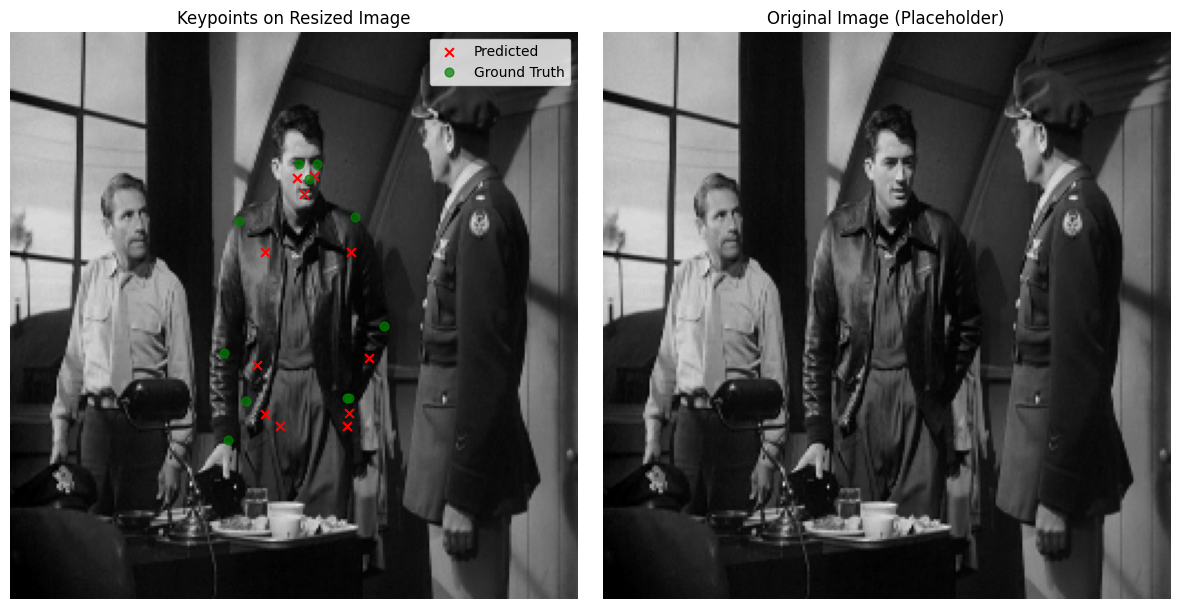

Image shape: (256, 256, 3)
Image range: 0.000 to 0.919
Predicted kpts range: 0.252 to 0.693
True kpts range: 0.232 to 0.719


In [11]:
def plot_keypoints_with_verification(image, keypoints_pred, keypoints_true=None):
    # Convert image from [0, 1] float to [0, 255] uint8 for display
    display_image = (image * 255).astype(np.uint8)

    # Denormalize keypoints from [0, 1] to pixel coordinates in resized image
    height, width = image.shape[:2]
    keypoints_pred = keypoints_pred * [width, height]

    if keypoints_true is not None:
        keypoints_true = keypoints_true * [width, height]

    plt.figure(figsize=(12, 6))

    # Plot 1: Keypoints on resized image
    plt.subplot(1, 2, 1)
    plt.imshow(display_image)
    plt.scatter(keypoints_pred[:, 0], keypoints_pred[:, 1],
                c='red', s=40, marker='x', label='Predicted')
    if keypoints_true is not None:
        plt.scatter(keypoints_true[:, 0], keypoints_true[:, 1],
                    c='green', s=40, marker='o', label='Ground Truth', alpha=0.7)
    plt.title('Keypoints on Resized Image')
    plt.axis('off')
    plt.legend()

    try:
        # Try to load the original image
        plt.subplot(1, 2, 2)
        # You'll need to modify this to get the correct file path
        # For now, we'll just show the resized image again
        plt.imshow(display_image)
        plt.title('Original Image (Placeholder)')
        plt.axis('off')
    except:
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, 'Could not load original image',
                 horizontalalignment='center', verticalalignment='center')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the visualization
test_iterator = iter(test_ds)
batch_images, batch_labels = next(test_iterator)

# Select a random sample
idx = np.random.choice(batch_images.shape[0])
img = batch_images[idx].numpy()
label = batch_labels[idx].numpy().reshape(-1, 2)

# Predict keypoints
pred = model.predict(tf.expand_dims(img, axis=0))[0].reshape(-1, 2)

# Visualize with verification
plot_keypoints_with_verification(img, pred, label)

# Debug info
print(f"Image shape: {img.shape}")
print(f"Image range: {img.min():.3f} to {img.max():.3f}")
print(f"Predicted kpts range: {pred.min():.3f} to {pred.max():.3f}")
print(f"True kpts range: {label.min():.3f} to {label.max():.3f}")